In [1]:
#!pip install bitsandbytes
#!pip install git+https://github.com/huggingface/transformers.git
#!pip install git+https://github.com/huggingface/peft.git
#!pip install git+https://github.com/huggingface/accelerate.git
#!pip install datasets scipy ipywidgets matplotlib
#!pip install sentencepiece
#!pip install wandb

In [2]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='dataset.json', split='train')
eval_dataset = load_dataset('json', data_files='validate.json', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [4]:

import wandb, os
wandb.login()

wandb_project = "teamprojekt-chatbot-pruefungsamt"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: benjaminbruenau (teamprojekt-chatbot-pruefungsamt). Use `wandb login --relogin` to force relogin


In [5]:
def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    return text

In [6]:
from huggingface_hub import notebook_login

notebook_login()
# how to do this with local file?
'''
 pip install huggingface_hub["cli"]
huggingface-cli delete-cache
huggingface-cli login

'''

'\n pip install huggingface_hub["cli"]\nhuggingface-cli delete-cache\nhuggingface-cli login\n\n'

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.3"#"../../../llms/mistral-7b-instruct-v0.2.Q4_K_M.gguf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [9]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

78


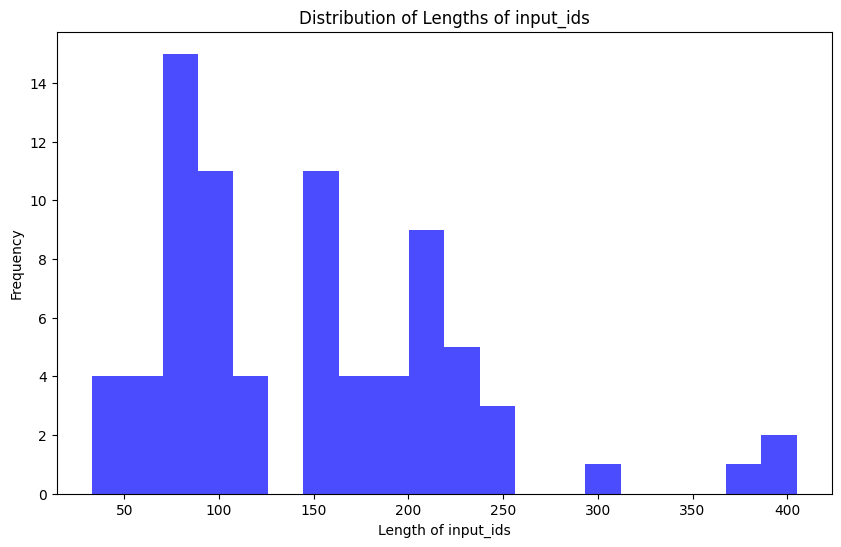

In [10]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [11]:
max_length = 200 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [12]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

[1, 1542, 23246, 29515, 2592, 1117, 1040, 12732, 1070, 1040, 10129, 1051, 11711, 5365, 1065, 4239, 1070, 4522, 4084, 29493, 1776, 29501, 13850, 29492, 4084, 29493, 1072, 4314, 8701, 12732, 29572, 781, 1542, 27075, 29515, 1183, 10129, 1051, 11711, 5365, 1117, 1227, 4825, 1065, 4239, 1070, 4522, 4084, 1065, 1040, 4625, 3526, 29491, 8930, 29493, 1146, 1117, 6165, 1158, 1032, 1776, 29501, 13850, 29492, 3256, 1137, 7463, 1770, 1040, 6305, 1066, 23741, 4100, 1072, 12817, 1032, 3468, 3141, 1032, 2846, 2602, 1070, 4649, 2181, 11237, 6330, 29491, 1183, 12732, 1070, 1224, 3256, 1117, 1751, 7200, 1254, 1032, 3716, 26094, 29493, 1330, 1476, 3716, 2242, 1070, 4084, 1117, 7851, 29491, 28723, 29493, 1246, 1279, 1641, 1137, 1392, 1181, 2154, 29503, 2073, 17303, 1066, 29473, 29538, 29502, 4084, 1070, 1539, 1093, 15450, 4522, 4084, 1072, 1776, 29501, 13850, 29492, 4084, 1377, 5345, 1040, 10129, 1051, 11711, 5365, 1117, 1512, 1070, 1032, 4314, 8701, 29510, 29481, 1539, 2536, 29493, 1458, 1117, 10334, 517

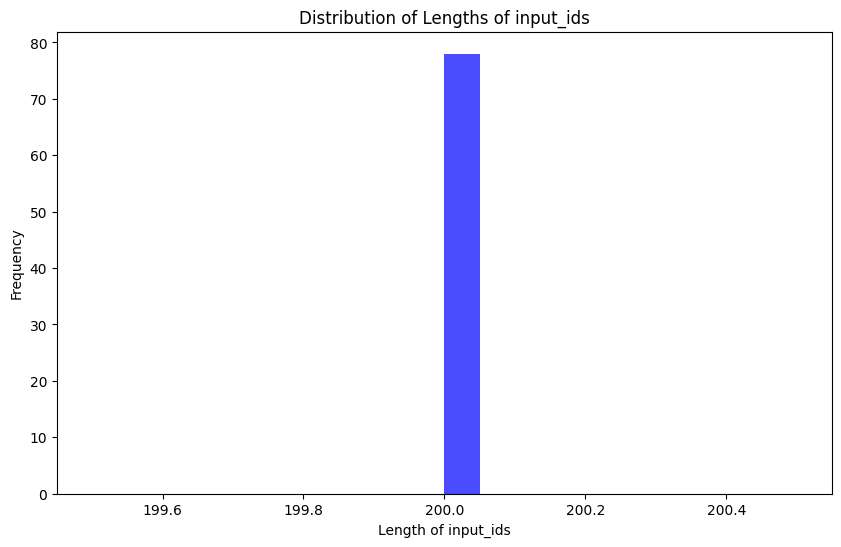

In [13]:
print(tokenized_train_dataset[1]['input_ids'])
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [14]:
eval_prompt = """ Given the following context, Welche Dokumente können als Nachweis für deutsche Sprachkenntnisse akzeptiert werden?

### Context:
§ 4 Sprachkenntnisse
(1) 1
Neben den allgemeinen Zugangsvoraussetzungen (§ 59 LHG) sind für die in § 1 Abs. 1
S. 1 genannten Studiengänge deutsche Sprachkenntnisse nachzuweisen. 2
Diese können
durch eine deutsche Hochschulzugangsberechtigung (u. a. erfolgreich abgeschlossenes
grundständiges Hochschulstudium) nachgewiesen werden. 3
Ferner kann der
Sprachnachweis durch die Vorlage eines der folgenden Dokumente erbracht werden:
1. Feststellungsprüfung für ein Bachelorstudium durch Vorlage der Zugangsberechtigung
des Studienkollegs an der Hochschule Konstanz,
2. Test Deutsch als Fremdsprache (TestDaF), sofern im Durchschnitt mindestens die
Stufe TDN 4 erreicht wurde,

Seite 5 von 43
3. Deutsche Sprachprüfung für den Hochschulzugang (DSH), sofern die DSH mit
mindestens der Stufe DSH-2 abgeschlossen wurde,
4. „Telc Deutsch C1 Hochschule“
oder eine äquivalente Sprachprüfung gemäß der Rahmenordnung über Deutsche
Sprachprüfungen für das Studium an deutschen Hochschulen (RO-DT). 4
Auf den Nachweis
einer deutschen Sprachprüfung kann bei Bewerberinnen und Bewerbern im besonders
begründeten Einzelfall verzichtet werden, insbesondere wenn sie die deutsche
Staatsangehörigkeit besitzen.
(2) 1
Sprachnachweise für den gewählten Studiengang, die durch die Bewerberin oder den
Bewerber bis zum Bewerbungsschluss nicht vorgelegt werden können, können bis zum
Vorlesungsbeginn des Semesters gemäß Terminplan der Hochschule Konstanz, für das der
Antrag auf Zulassung gestellt wurde, nachgereicht werden. 2
Die Zulassung erfolgt in diesem
Fall gemäß § 6 Abs. 5 unter Vorbehalt.
(3) 1
Für Zeitstudierende gelten die Regelungen in § 10 Zulassungs- und
Immatrikulationsordnung (ZIO) der Hochschule Konstanz

### ANSWER:
"""

In [15]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Given the following context, Welche Dokumente können als Nachweis für deutsche Sprachkenntnisse akzeptiert werden?

### Context:
§ 4 Sprachkenntnisse
(1) 1
Neben den allgemeinen Zugangsvoraussetzungen (§ 59 LHG) sind für die in § 1 Abs. 1
S. 1 genannten Studiengänge deutsche Sprachkenntnisse nachzuweisen. 2
Diese können
durch eine deutsche Hochschulzugangsberechtigung (u. a. erfolgreich abgeschlossenes
grundständiges Hochschulstudium) nachgewiesen werden. 3
Ferner kann der
Sprachnachweis durch die Vorlage eines der folgenden Dokumente erbracht werden:
1. Feststellungsprüfung für ein Bachelorstudium durch Vorlage der Zugangsberechtigung
des Studienkollegs an der Hochschule Konstanz,
2. Test Deutsch als Fremdsprache (TestDaF), sofern im Durchschnitt mindestens die
Stufe TDN 4 erreicht wurde,

Seite 5 von 43
3. Deutsche Sprachprüfung für den Hochschulzugang (DSH), sofern die DSH mit
mindestens der Stufe DSH-2 abgeschlossen wurde,
4. „Telc Deutsch C1 Hochschule“
oder eine äquivalente Sprac

# LoRA

In [16]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [17]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [18]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32768, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

In [19]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85065728 || all params: 3843428352 || trainable%: 2.213277319342624


In [20]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32768, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k

# Training


In [21]:
'''
if torch.cuda.device_count() > 1:
    model.is_parallelizable = True
    model.model_parallel = True
'''
model = accelerator.prepare_model(model)

In [22]:
import transformers
from datetime import datetime

project = "chatbot-pruefungsamt-finetune"
#base_model_name = "mistral"
run_name = base_model_id + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=2,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/home/tpllmws23/environments/finetuning/lib/python3.11/site-packages/transformers/training_args.py:1493: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


/home/tpllmws23/environments/finetuning/lib/python3.11/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,1.411100,1.126592
50,0.600000,1.126773
75,0.296600,1.203004
100,0.156100,1.324408
125,0.124500,1.401369
150,0.081000,1.419397
175,0.061500,1.558133
200,0.059000,1.614821
225,0.049700,1.532672
250,0.045000,1.630227


/home/tpllmws23/environments/finetuning/lib/python3.11/site-packages/peft/utils/save_and_load.py:197: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/tpllmws23/environments/finetuning/lib/python3.11/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/tpllmws23/environments/finetuning/lib/python3.11/site-packages/peft/utils/save_and_load.py:197: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_module

TrainOutput(global_step=500, training_loss=0.16223557472229003, metrics={'train_runtime': 2075.0053, 'train_samples_per_second': 0.482, 'train_steps_per_second': 0.241, 'total_flos': 8465872945152000.0, 'train_loss': 0.16223557472229003, 'epoch': 20.0})

# Kill Kernel and Try the finetuned model

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

#base_model_id = "mistralai/Mistral-7B-v0.3"
#project = "chatbot-pruefungsamt-finetune"

base_model_id = "mistralai/Mistral-7B-v0.3"
project = "journal-finetune"
run_name = base_model_id + "-" + project


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
from peft import PeftModel

#ft_model = PeftModel.from_pretrained(base_model, run_name + "/checkpoint-500")
ft_model = PeftModel.from_pretrained(base_model, "mistral-journal-finetune/checkpoint-500")

In [4]:
eval_prompt = "Welche Dokumente können als Nachweis für deutsche Sprachkenntnisse akzeptiert werden?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.15)[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Welche Dokumente können als Nachweis für deutsche Sprachkenntnisse akzeptiert werden?
 ### A. Die folgenden Dokumente können als Nachweis für deutsche Sprachkenntnisse akzeptiert werden: (1) Feststellungsprüfung für ein Bachelorstudium durch Vorlage der Zugangsberechtigung des Studienkollegs an der Hochschule Konstanz, (2) Test Deutsch als Fremdsprache (TestDaF) mit mindestens der Stufe TDN 4, (3) Deutsche Sprachprüfung für den Hochschulzugang (DSH) mit mindestens der Stufe DSH-2, (4) „Telc Deutsch C1 Hochschule“ oder eine äquivalente Sprachprüfung gemäß der Rahmenordnung über Deutsche Sprachprüfungen für das Hochschulstudium in Rheinland-Pfalz vom 8. April 2015 (Geltungsbereich: Landeshochschulen in Rheinland-Pfalz), (5) „Certifikat Deutsche Sprache (C1) für den Hochschulbereich“ gemäß der Vorentwurf-Verordnung über Deutsche Sprachprüfungen für das Hochschulstudium in Baden-Würtemberg vom 7. November 2016 (
